# 🧪 Workshop 1: From Gradient Flow to Optimisation Intuition
> This is the worked version of the notebook.
>
> Model answer and executive summary for the problem can be found in this notebook.

This set of workshops builds on Tutorials 1–4 and closes **Part 1** of the series, consolidating core ideas about PyTorch `autograd` and gradient flow before moving on to explicit optimisation in and Part 2.

Rather than treating gradients as black-box training signals, the workshop emphasises **gradients as sensitivity measures**, especially in settings where model outputs are **tensor-valued** and gradients are computed using **explicit upstream directions**.

---
**The problems are designed to shift perspective**:
- from *“what gradient does PyTorch give me?”*
- to *“what does this gradient represent, and why?”*
---
**The emphasis is on developing intuition for**:
- how gradients flow through structured linear and nonlinear computations,
- how upstream gradients select directions in output space,
- how `.grad` reflects sensitivity rather than optimisation,
- and how gradient structure anticipates optimisation behaviour.
---
**Key ideas explored include**:
- vector–Jacobian products as the fundamental object computed by `backward(v)`,
- the role of upstream gradients in shaping gradient flow,
- sparsity and structure in gradients induced by linear maps and nonlinearities (e.g., ReLU),
- interpreting gradients statistically and geometrically rather than procedurally,
- and using controlled experiments to reason about gradient behaviour.
---
**This workshop serves as a conceptual bridge between**:
- `autograd` mechanics and gradient flow (Tutorials 3–4),
- and **objective design and optimisation dynamics** (Workshop 2 and Part 2).

The focus is intentionally *not* on training pipelines, datasets, or optimisers, but on understanding how gradients behave in controlled settings—laying the groundwork for effective optimisation.

---
**Recommended prerequisites**:
- Familiarity with PyTorch tensors and `.backward()`
- Understanding of scalar vs tensor-valued gradients
- Basic comfort with linear algebra and nonlinear activations

---

**Author: Angze Li**

**Last updated: 2026-02-19**

**Version: v1.1**

## 🧩 Problem: Sensitivity of a Feature Transformation

>In many models, inputs are transformed into feature representations before being used by a downstream objective.
> Understanding which inputs influence which features is critical for interpretability and optimisation.

Consider the following setup:
```python
x = torch.randn(6, requires_grad=True)

W = torch.tensor([
    [1.0,  0.0,  0.0, 0.0, 0.0, 0.0],
    [0.0,  1.0,  0.0, 0.0, 0.0, 0.0],
    [0.0,  0.0,  2.0, 0.0, 0.0, 0.0],
    [0.0,  0.0,  0.0, 3.0, 0.0, 0.0],
], requires_grad=False)

out = torch.relu(W @ x) # what does this line do?
```
This produces a 4-dimensional tensor output, not a scalar.

---

### Task
1.	Construct an upstream gradient vector `v` such that:
    - the last feature of out is weighted most heavily,
    - the first two features are ignored.
2. Call:
```python
out.backward(v)
```
3. Inspect `x.grad`.

---

### Questions to think about
- Which components of `x` receive non-zero gradients?
- How does the structure of `W` affect gradient flow?
- How does ReLU change which inputs are “active”?
- Why is `x.grad` sparse in some cases?

---

### Hint

> Think in terms of which inputs influence which outputs, and which outputs are being emphasised by `v`.

---

### Learning outcomes

After this problem, you should be comfortable with:
- interpreting `.grad` as a sensitivity map,
- reasoning about gradient flow through linear + nonlinear layers,
- understanding how upstream weighting reshapes gradient influence.

This problem bridges Tutorials 3 and 4 cleanly and warms up the optimisation mindset.

---
**Author**: Angze Li

**Last updated**: 2026-02-20

**Version**: v2.0

## Solution

In [1]:
%%time
import torch
import numpy as np

W = torch.tensor([
        [1.0,  0.0,  0.0, 0.0, 0.0, 0.0],
        [0.0,  1.0,  0.0, 0.0, 0.0, 0.0],
        [0.0,  0.0,  2.0, 0.0, 0.0, 0.0],
        [0.0,  0.0,  0.0, 3.0, 0.0, 0.0],
    ], requires_grad=False)

weight = np.linspace(0.01,0.50,20)
repeats = 100000
x_grad0, x_grad2, x_grad3, x_grad_ratio = [], [], [], []

for i in range(len(weight)):
    v = torch.zeros(4)
    v[2] = weight[i]
    v[3] = 1-weight[i]

    x_grad_sum = torch.zeros(6)
    
    for j in range(repeats): 
        x = torch.randn(6, requires_grad=True)
        out = torch.relu(W @ x)
        out.backward(v)

        with torch.no_grad():
            x_grad_sum += x.grad

    print(f"Iteration {i}, Weight {round(weight[i],3)}, Monte Carlo average of x_grad: {x_grad_sum/repeats}")
    x_grad_ratio.append(float(x_grad_sum[3]/x_grad_sum[2]))
    x_grad3.append(x_grad_sum[3]/repeats)
    x_grad2.append(x_grad_sum[2]/repeats)
    x_grad0.append(x_grad_sum[0]/repeats)

print(f"\nAveraged x_grad[3]/x_grad[2] at each weight:\n {x_grad_ratio}")

Iteration 0, Weight 0.01, Monte Carlo average of x_grad: tensor([0.0000, 0.0000, 0.0099, 1.4869, 0.0000, 0.0000])
Iteration 1, Weight 0.036, Monte Carlo average of x_grad: tensor([0.0000, 0.0000, 0.0358, 1.4348, 0.0000, 0.0000])
Iteration 2, Weight 0.062, Monte Carlo average of x_grad: tensor([0.0000, 0.0000, 0.0615, 1.4029, 0.0000, 0.0000])
Iteration 3, Weight 0.087, Monte Carlo average of x_grad: tensor([0.0000, 0.0000, 0.0873, 1.3617, 0.0000, 0.0000])
Iteration 4, Weight 0.113, Monte Carlo average of x_grad: tensor([0.0000, 0.0000, 0.1128, 1.3395, 0.0000, 0.0000])
Iteration 5, Weight 0.139, Monte Carlo average of x_grad: tensor([0.0000, 0.0000, 0.1394, 1.3006, 0.0000, 0.0000])
Iteration 6, Weight 0.165, Monte Carlo average of x_grad: tensor([0.0000, 0.0000, 0.1644, 1.2558, 0.0000, 0.0000])
Iteration 7, Weight 0.191, Monte Carlo average of x_grad: tensor([0.0000, 0.0000, 0.1909, 1.2098, 0.0000, 0.0000])
Iteration 8, Weight 0.216, Monte Carlo average of x_grad: tensor([0.0000, 0.0000,

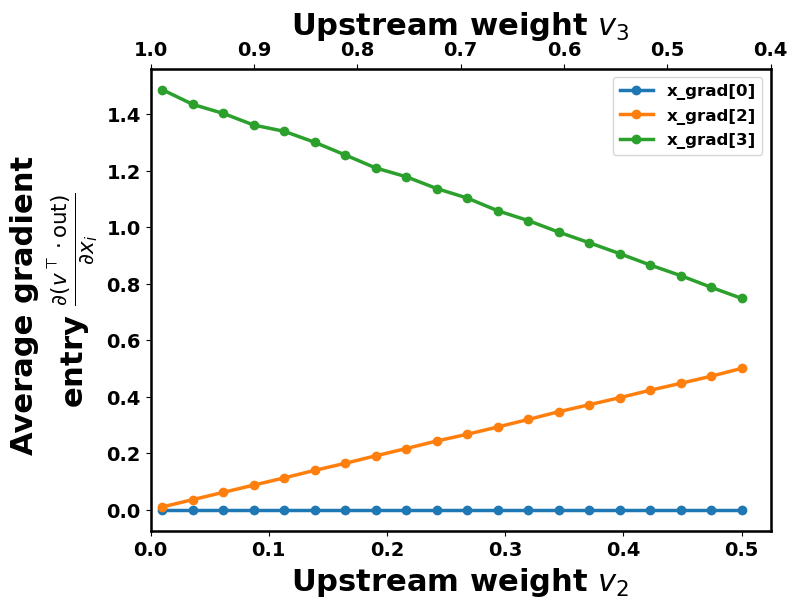

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
ax = plt.gca()
for spine in ax.spines.values():
        spine.set_linewidth(1.8)


plt.plot(weight, np.array(x_grad0), '-o', linewidth=2.5, label="x_grad[0]")
plt.plot(weight, np.array(x_grad2), '-o', linewidth=2.5, label="x_grad[2]")
plt.plot(weight, np.array(x_grad3), '-o', linewidth=2.5, label="x_grad[3]")
plt.xlim(0)
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(loc='upper right',prop={"size": 12, "weight": "bold"})
plt.xlabel(r"Upstream weight $v_2$", fontsize=22, fontweight='bold')
plt.ylabel("Average gradient \n"r"entry $\frac{\partial (v^\top \cdot \mathrm{out})}{\partial x_i}$", fontsize=22, fontweight='bold')

ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ticks = ax.get_xticks()
ax_top.set_xticks(ticks)
ax_top.set_xticklabels([f"{1 - t:.1f}" for t in ticks],fontsize=14, fontweight='bold')
ax_top.set_xlabel(r"Upstream weight $v_3$", fontsize=22, fontweight='bold')

plt.show()

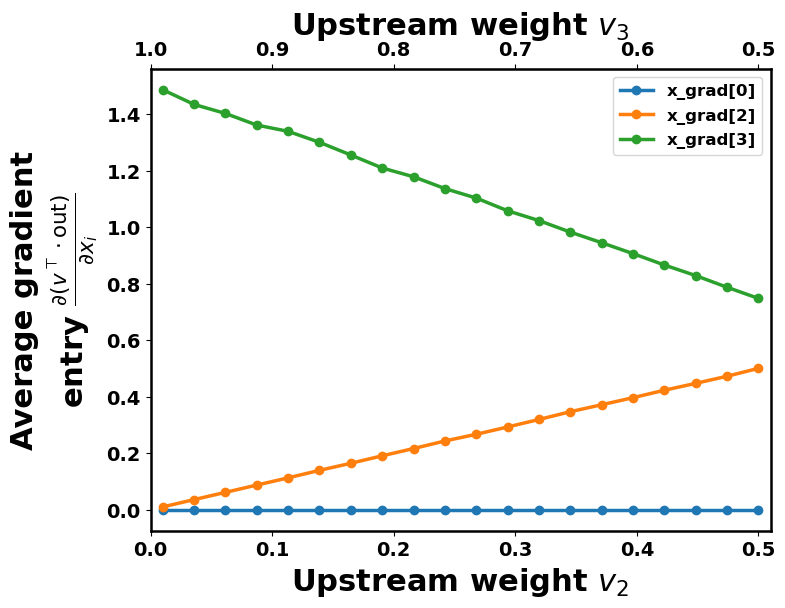

In [3]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

for spine in ax.spines.values():
    spine.set_linewidth(1.8)

ax.plot(weight, np.array(x_grad0), "-o", lw=2.5, label="x_grad[0]")
ax.plot(weight, np.array(x_grad2), "-o", lw=2.5, label="x_grad[2]")
ax.plot(weight, np.array(x_grad3), "-o", lw=2.5, label="x_grad[3]")


ax.set(xlim=(0, 0.51),
       xlabel=r"Upstream weight $v_2$",
       ylabel="Average gradient\n"
              r"entry $\frac{\partial (v^\top\cdot \mathrm{out})}{\partial x_i}$")
ax.xaxis.label.set_fontsize(22)
ax.yaxis.label.set_fontsize(22)
ax.xaxis.label.set_fontweight("bold")
ax.yaxis.label.set_fontweight("bold")

ax.tick_params(axis="both", labelsize=14)
ax.legend(loc="upper right", prop={"size": 12, "weight": "bold"})


secax = ax.secondary_xaxis("top", functions=(lambda v2: 1 - v2, lambda v3: 1 - v3))
secax.set(xlabel=r"Upstream weight $v_3$")
secax.xaxis.label.set_fontsize(22)
secax.xaxis.label.set_fontweight("bold")

bottom = ax.get_xticks()
secax.set_xticks(1 - bottom)
secax.set_xticklabels([f"{t:.1f}" for t in 1 - bottom])
secax.tick_params(axis="x", labelsize=14)

for t in ax.get_xticklabels() + ax.get_yticklabels() + secax.get_xticklabels():
    t.set_fontweight("bold")
ax.xaxis.label.set_fontweight("bold")
ax.yaxis.label.set_fontweight("bold")
secax.xaxis.label.set_fontweight("bold")

plt.show()

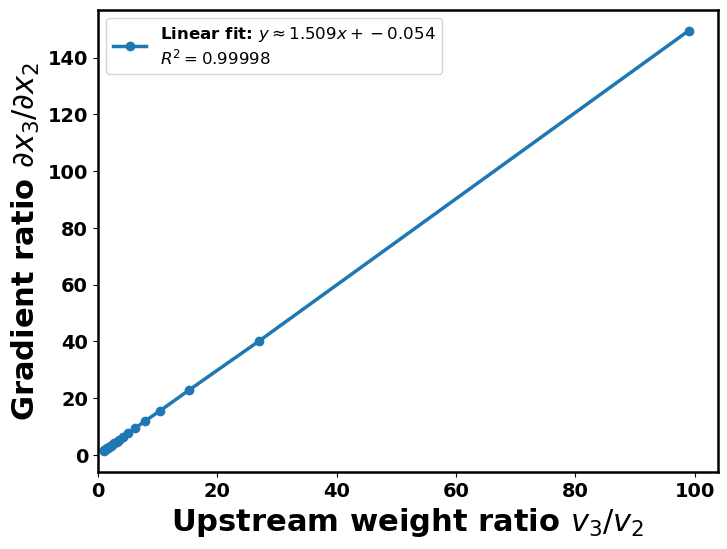

In [4]:
weight_ratio = (1 - weight) / weight
x_grad_ratio = np.array(x_grad_ratio)

m, c = np.polyfit(weight_ratio, x_grad_ratio, 1)
x_grad_fit = m * weight_ratio + c

ss_res = np.sum((x_grad_ratio - x_grad_fit) ** 2)
ss_tot = np.sum((x_grad_ratio - np.mean(x_grad_ratio)) ** 2)
R2 = 1 - ss_res / ss_tot if ss_tot != 0 else np.nan

fig, ax = plt.subplots(figsize=(8, 6))
for spine in ax.spines.values():
    spine.set_linewidth(1.8)

ax.plot(weight_ratio, x_grad_ratio, '-o', linewidth=2.5, label=rf"Linear fit: $y \approx {m:.3f}x + {c:.3f}$" f"\n$R^2 = {R2:.5f}$")

ax.set_xlim(0)
ax.set_xlabel(r"Upstream weight ratio $v_3 / v_2$")
ax.set_ylabel(r"Gradient ratio $\partial x_3 / \partial x_2$")

ax.xaxis.label.set_fontsize(22)
ax.yaxis.label.set_fontsize(22)
ax.xaxis.label.set_fontweight("bold")
ax.yaxis.label.set_fontweight("bold")

ax.tick_params(axis='both', labelsize=14)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight("bold")

ax.legend(loc='upper left', prop={"size": 12, "weight": "bold"})

plt.show()

## Executive summary

### Understanding the solution

This exercise explores how gradients flow through a simple linear–nonlinear system when the output is tensor-valued and gradients are computed via a vector–Jacobian product.

The model we studied is:
$$\text{out} = \operatorname{ReLU}(W x),$$
with a user-chosen upstream gradient `v` supplied to `backward()`.


### Which components of `x` receive non-zero gradients?

Only a **subset of the components of `x`** ever receive non-zero gradients.

This happens for two reasons:
1. **Linear structure**: Each row of `W` depends only on one component of `x.

    As a result, each output entry is influenced by exactly one input coordinate.
2. **Upstream weighting**: Only the output components with non-zero entries in `v` contribute to the gradient.

If a component of `x` does not influence any weighted output entry, its gradient is exactly zero.

### How does the structure of `W` affect gradient flow?

The matrix `W` acts as a **routing mechanism** for gradients.

Because `W` is sparse and diagonal-like:
- each output dimension maps directly to a single input dimension,
- gradient flow is strictly localised,
- there is no mixing between unrelated components of `x`.

This makes the gradient behaviour easy to interpret:
changing the weight of one output only affects the gradient of its corresponding input.

### How does ReLU change which inputs are “active”?

ReLU introduces **input-dependent gating**.

For each output component:
$$
\operatorname{ReLU}(z) =
\begin{cases}
z, & z > 0 \\
0, & z \le 0
\end{cases}
$$

This means:
- gradients flow **only when the pre-activation is positive**,
- inputs corresponding to negative pre-activations are *temporarily invisible* to backpropagation.

In this exercise, averaging gradients over many random samples reveals that:
- each active ReLU contributes gradients roughly **half** the time,
- inactive paths contribute nothing.

This explains the appearance of **fractional average gradients** in the Monte Carlo results.

### Why is `x.grad` sparse in some cases?

`x.grad` is sparse because gradient flow is conditional:
- conditional on which outputs are weighted by `v`,
- conditional on which ReLU units are active,
- conditional on the sparsity pattern of `W`.

If any link in this chain is broken (zero weight, inactive ReLU, or missing linear connection), the gradient for that input vanishes.

This sparsity is not a numerical artifact — it is a structural property of the computation graph.

### Why are the figures necessary?

The figures serve two essential purposes.

**1. Revealing how upstream weights redistribute gradients**

The first figure shows how changing the upstream weights `v` **redistributes gradient magnitude** across different input components.

While the total sensitivity remains bounded, its allocation shifts smoothly as `v` changes.
This visually reinforces the idea that:

> vector–Jacobian products do not create new gradients — they reweight existing ones.

**2. Confirming a linear relationship between gradient ratios and weight ratios**

The second figure plots:

$$
\frac{\partial x_3}{\partial x_2}
\quad \text{vs.} \quad
\frac{v_3}{v_2}
$$
The near-perfect linear relationship confirms that:
- gradient ratios scale linearly with upstream weight ratios,
- the computation behaves exactly as predicted by the chain rule,
- ReLU’s gating only affects *when* gradients flow, not *how* they scale once active.

This provides strong empirical validation of the theory behind vector–Jacobian products.

## 🧭 Closing Remarks

This exercise demonstrates that in PyTorch:
- gradients of tensor-valued outputs are **not single objects**, but **directional sensitivities**,
- `backward(v)` computes how a *chosen direction in output space* propagates back to inputs,
- sparsity and structure in gradients arise naturally from the computation graph itself.

Together, the code and figures make vector–Jacobian products concrete, intuitive, and experimentally verifiable — exactly the conceptual bridge needed before moving on to optimisation in Part 2.